In [4]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
data = pd.read_excel("K214142101_Đinh Nguyễn Khánh Dương.xlsx", sheet_name = 'Data')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5736 entries, 0 to 5735
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Code          5736 non-null   object        
 1   Date          5736 non-null   datetime64[ns]
 2   assets        5694 non-null   float64       
 3   equity        5694 non-null   float64       
 4   liabilities   5695 non-null   float64       
 5   receivables   5694 non-null   float64       
 6   fixed assets  5680 non-null   float64       
 7   revenue       5707 non-null   float64       
 8   expenses      5707 non-null   float64       
 9   ni            5707 non-null   float64       
 10  cogs          5707 non-null   float64       
 11  cfo           5703 non-null   float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 537.9+ KB


In [6]:
data['Year'] = pd.DatetimeIndex(data['Date']).year
data = data.drop(columns=['Date'])
data.head()

,Code,assets,equity,liabilities,receivables,fixed assets,revenue,expenses,ni,cogs,cfo,Year
0,CHP.HM,3.255272e+12,1.626087e+12,1.629185e+12,2.100323e+11,2.730589e+12,7.293103e+11,3.900740e+10,3.283011e+11,2.424981e+11,5.176216e+11,2015
1,CHP.HM,3.083763e+12,1.670162e+12,1.413600e+12,2.750112e+11,2.553702e+12,6.496894e+11,3.772757e+10,2.577748e+11,2.526228e+11,3.467132e+11,2016
2,CHP.HM,3.105531e+12,1.878897e+12,1.226634e+12,1.207981e+11,2.395522e+12,8.605339e+11,4.544404e+10,4.103341e+11,2.956443e+11,7.152392e+11,2017
3,CHP.HM,2.848967e+12,1.760880e+12,1.088086e+12,2.872044e+11,2.413420e+12,4.700184e+11,2.953540e+10,9.589232e+10,2.653131e+11,3.180617e+10,2018
4,CHP.HM,3.611673e+12,1.764243e+12,1.847430e+12,1.632510e+11,3.191064e+12,7.135358e+11,3.231854e+10,2.160548e+11,3.304130e+11,5.570416e+11,2019


In [7]:
print ("Rows, Columns    : " , data.shape)
print ("\nVariables : " ,data.columns.tolist())

Rows, Columns    :  (5736, 12)

Variables :  ['Code', 'assets', 'equity', 'liabilities', 'receivables', 'fixed assets', 'revenue', 'expenses', 'ni', 'cogs', 'cfo', 'Year']


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5736 entries, 0 to 5735
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Code          5736 non-null   object 
 1   assets        5694 non-null   float64
 2   equity        5694 non-null   float64
 3   liabilities   5695 non-null   float64
 4   receivables   5694 non-null   float64
 5   fixed assets  5680 non-null   float64
 6   revenue       5707 non-null   float64
 7   expenses      5707 non-null   float64
 8   ni            5707 non-null   float64
 9   cogs          5707 non-null   float64
 10  cfo           5703 non-null   float64
 11  Year          5736 non-null   int32  
dtypes: float64(10), int32(1), object(1)
memory usage: 515.5+ KB


TÍNH AEM (ACCRUAL BASED EARNINGS MANAGEMENT)

In [9]:
aem_data = data.copy()

In [10]:
#Tính các biến cần tính theo mỗi công ty
aem_data['Assets_t_1'] = aem_data.groupby('Code')['assets'].shift(1)
aem_data['TA_adj'] = (aem_data['ni'] - aem_data['cfo'])/aem_data['Assets_t_1']
aem_data['delta_Rev'] = aem_data.groupby('Code')['revenue'].diff()
aem_data['delta_Rec'] = aem_data.groupby('Code')['receivables'].diff()
# Tính các biến khác
aem_data['inv_Assets_t_1'] = 1 / aem_data['Assets_t_1']
aem_data['delta_Rev_Rec'] = (aem_data['delta_Rev'] - aem_data['delta_Rec']) / aem_data['Assets_t_1']
aem_data['PPE'] = aem_data['fixed assets'] / aem_data['Assets_t_1']
aem_data.head()

,Code,assets,equity,liabilities,receivables,fixed assets,revenue,expenses,ni,cogs,cfo,Year,Assets_t_1,TA_adj,delta_Rev,delta_Rec,inv_Assets_t_1,delta_Rev_Rec,PPE
0,CHP.HM,3.255272e+12,1.626087e+12,1.629185e+12,2.100323e+11,2.730589e+12,7.293103e+11,3.900740e+10,3.283011e+11,2.424981e+11,5.176216e+11,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHP.HM,3.083763e+12,1.670162e+12,1.413600e+12,2.750112e+11,2.553702e+12,6.496894e+11,3.772757e+10,2.577748e+11,2.526228e+11,3.467132e+11,2016,3.255272e+12,-0.027321,-7.962093e+10,6.497890e+10,3.071940e-13,-0.044420,0.784482
2,CHP.HM,3.105531e+12,1.878897e+12,1.226634e+12,1.207981e+11,2.395522e+12,8.605339e+11,4.544404e+10,4.103341e+11,2.956443e+11,7.152392e+11,2017,3.083763e+12,-0.098874,2.108445e+11,-1.542131e+11,3.242791e-13,0.118381,0.776818
3,CHP.HM,2.848967e+12,1.760880e+12,1.088086e+12,2.872044e+11,2.413420e+12,4.700184e+11,2.953540e+10,9.589232e+10,2.653131e+11,3.180617e+10,2018,3.105531e+12,0.020636,-3.905155e+11,1.664063e+11,3.220061e-13,-0.179332,0.777136
4,CHP.HM,3.611673e+12,1.764243e+12,1.847430e+12,1.632510e+11,3.191064e+12,7.135358e+11,3.231854e+10,2.160548e+11,3.304130e+11,5.570416e+11,2019,2.848967e+12,-0.119688,2.435174e+11,-1.239535e+11,3.510044e-13,0.128984,1.120078


In [11]:
# Drop các dòng có Na (do lagging)
aem_data = aem_data.dropna(subset = ['inv_Assets_t_1', 'delta_Rev_Rec', 'PPE'])

In [12]:
# Chạy mô hình hồi quy để ước tính các hệ số
X = aem_data[['inv_Assets_t_1', 'delta_Rev_Rec', 'PPE']]
X = sm.add_constant(X)
y = aem_data['TA_adj']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 TA_adj   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     5475.
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:39:12   Log-Likelihood:                -1664.4
No. Observations:                4999   AIC:                             3337.
Df Residuals:                    4995   BIC:                             3363.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0621      0.005    -11.

In [13]:
alpha1 = model.params['inv_Assets_t_1']
alpha2 = model.params['delta_Rev_Rec']
alpha3 = model.params['PPE']
# Tính NDA, từ đó tính AEM (hay DA)
aem_data['NDA'] = alpha1 * aem_data['inv_Assets_t_1'] + alpha2 * aem_data['delta_Rev_Rec'] + alpha3 * aem_data['PPE'] 
aem_data['AEM'] = aem_data['TA_adj'] - aem_data['NDA']
aem_data.head()

,Code,assets,equity,liabilities,receivables,fixed assets,revenue,expenses,ni,cogs,...,Year,Assets_t_1,TA_adj,delta_Rev,delta_Rec,inv_Assets_t_1,delta_Rev_Rec,PPE,NDA,AEM
1,CHP.HM,3.083763e+12,1.670162e+12,1.413600e+12,2.750112e+11,2.553702e+12,6.496894e+11,3.772757e+10,2.577748e+11,2.526228e+11,...,2016,3.255272e+12,-0.027321,-7.962093e+10,6.497890e+10,3.071940e-13,-0.044420,0.784482,0.173696,-0.201017
2,CHP.HM,3.105531e+12,1.878897e+12,1.226634e+12,1.207981e+11,2.395522e+12,8.605339e+11,4.544404e+10,4.103341e+11,2.956443e+11,...,2017,3.083763e+12,-0.098874,2.108445e+11,-1.542131e+11,3.242791e-13,0.118381,0.776818,0.165268,-0.264143
3,CHP.HM,2.848967e+12,1.760880e+12,1.088086e+12,2.872044e+11,2.413420e+12,4.700184e+11,2.953540e+10,9.589232e+10,2.653131e+11,...,2018,3.105531e+12,0.020636,-3.905155e+11,1.664063e+11,3.220061e-13,-0.179332,0.777136,0.177817,-0.157181
4,CHP.HM,3.611673e+12,1.764243e+12,1.847430e+12,1.632510e+11,3.191064e+12,7.135358e+11,3.231854e+10,2.160548e+11,3.304130e+11,...,2019,2.848967e+12,-0.119688,2.435174e+11,-1.239535e+11,3.510044e-13,0.128984,1.120078,0.239581,-0.359269
5,CHP.HM,3.532765e+12,1.893862e+12,1.638903e+12,1.766710e+11,3.017281e+12,8.305249e+11,3.744743e+10,2.783721e+11,3.728145e+11,...,2020,3.611673e+12,-0.063386,1.169891e+11,1.342001e+10,2.768800e-13,0.028676,0.835425,0.181588,-0.244974


In [14]:
data = data.merge(aem_data[['Code', 'Year', 'AEM']], on=['Code', 'Year'], how='left')
data.head()

,Code,assets,equity,liabilities,receivables,fixed assets,revenue,expenses,ni,cogs,cfo,Year,AEM
0,CHP.HM,3.255272e+12,1.626087e+12,1.629185e+12,2.100323e+11,2.730589e+12,7.293103e+11,3.900740e+10,3.283011e+11,2.424981e+11,5.176216e+11,2015,NaN
1,CHP.HM,3.083763e+12,1.670162e+12,1.413600e+12,2.750112e+11,2.553702e+12,6.496894e+11,3.772757e+10,2.577748e+11,2.526228e+11,3.467132e+11,2016,-0.201017
2,CHP.HM,3.105531e+12,1.878897e+12,1.226634e+12,1.207981e+11,2.395522e+12,8.605339e+11,4.544404e+10,4.103341e+11,2.956443e+11,7.152392e+11,2017,-0.264143
3,CHP.HM,2.848967e+12,1.760880e+12,1.088086e+12,2.872044e+11,2.413420e+12,4.700184e+11,2.953540e+10,9.589232e+10,2.653131e+11,3.180617e+10,2018,-0.157181
4,CHP.HM,3.611673e+12,1.764243e+12,1.847430e+12,1.632510e+11,3.191064e+12,7.135358e+11,3.231854e+10,2.160548e+11,3.304130e+11,5.570416e+11,2019,-0.359269


In [15]:
data.isnull().sum()

Code              0
assets           42
equity           42
liabilities      41
receivables      42
fixed assets     56
revenue          29
expenses         29
ni               29
cogs             29
cfo              33
Year              0
AEM             737
dtype: int64

Cột AEM bị missing values nhiều, cụ thể là ở năm 2015 vì trong lúc tính toán có sử dụng các biến trễ một năm

In [16]:
# Drop rows with NaN values
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['AEM'])
data.isnull().sum()

Code            0
assets          0
equity          0
liabilities     0
receivables     0
fixed assets    0
revenue         0
expenses        0
ni              0
cogs            0
cfo             0
Year            0
AEM             0
dtype: int64

In [17]:
data = data.drop(columns=['Code','Year'])
data.describe()

,assets,equity,liabilities,receivables,fixed assets,revenue,expenses,ni,cogs,cfo,AEM
count,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4.999000e+03,4999.000000
mean,5.018370e+12,2.088481e+12,2.929889e+12,8.165646e+11,1.466973e+12,3.397859e+12,3.089941e+11,2.532630e+11,2.797935e+12,2.599021e+11,-0.062140
std,2.322081e+13,8.249019e+12,1.590087e+13,4.018081e+12,8.006778e+12,1.293570e+13,1.473155e+12,1.464272e+12,1.103297e+13,1.671976e+12,0.337597
min,1.344193e+10,-1.702593e+13,9.848030e+07,4.035255e+06,0.000000e+00,-1.545201e+12,-1.097956e+12,-1.327899e+13,-1.375299e+12,-1.817499e+13,-16.815612
25%,3.120447e+11,1.643505e+11,1.003261e+11,4.662016e+10,3.307272e+10,2.418768e+11,1.795452e+10,8.485571e+09,1.818549e+11,-4.877666e+09,-0.163012
50%,9.044062e+11,4.068710e+11,3.999334e+11,1.656030e+11,1.287325e+11,7.062857e+11,5.329882e+10,3.222553e+10,5.383393e+11,3.272489e+10,-0.072160
75%,2.472747e+12,1.159026e+12,1.447635e+12,5.155167e+11,5.772881e+11,2.039831e+12,1.571875e+11,1.220884e+11,1.683978e+12,1.655821e+11,0.012701
max,6.676558e+14,1.826363e+14,5.194341e+14,1.401276e+14,2.219902e+14,3.040638e+14,2.693133e+13,3.894848e+13,2.917442e+14,5.316047e+13,7.597214


EXPLORATORY DATA ANALYSIS 

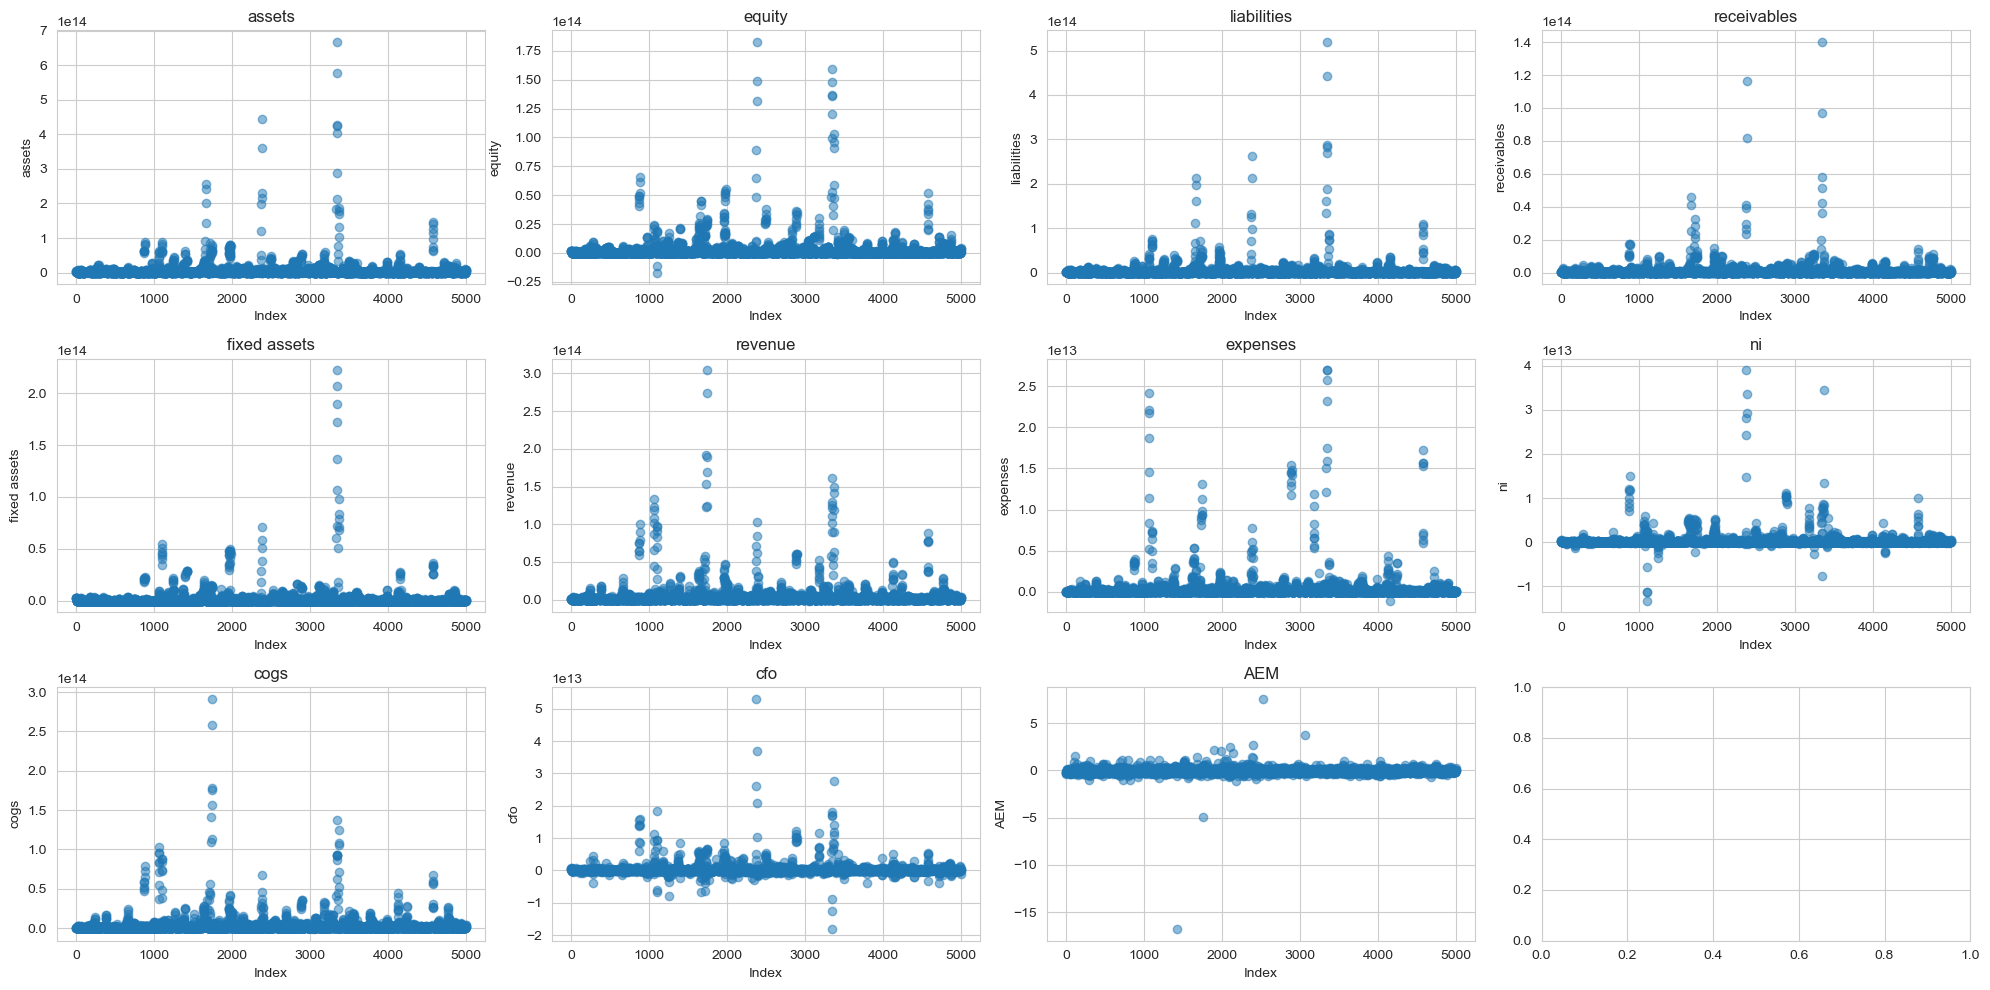

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot scatter plots for each column
for i, col in enumerate(data.columns):
    axs[i].scatter(range(len(data[col])), data[col], alpha=0.5)
    axs[i].set_title(col)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(col)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

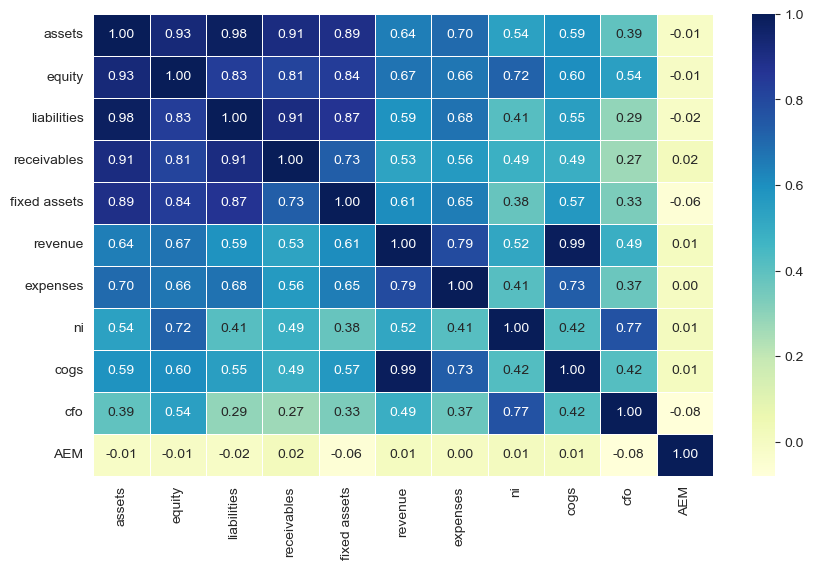

In [19]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5)

# Set titles and labels
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12236\934823636.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12236\934823636.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12236\934823636.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12236\934823636.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your

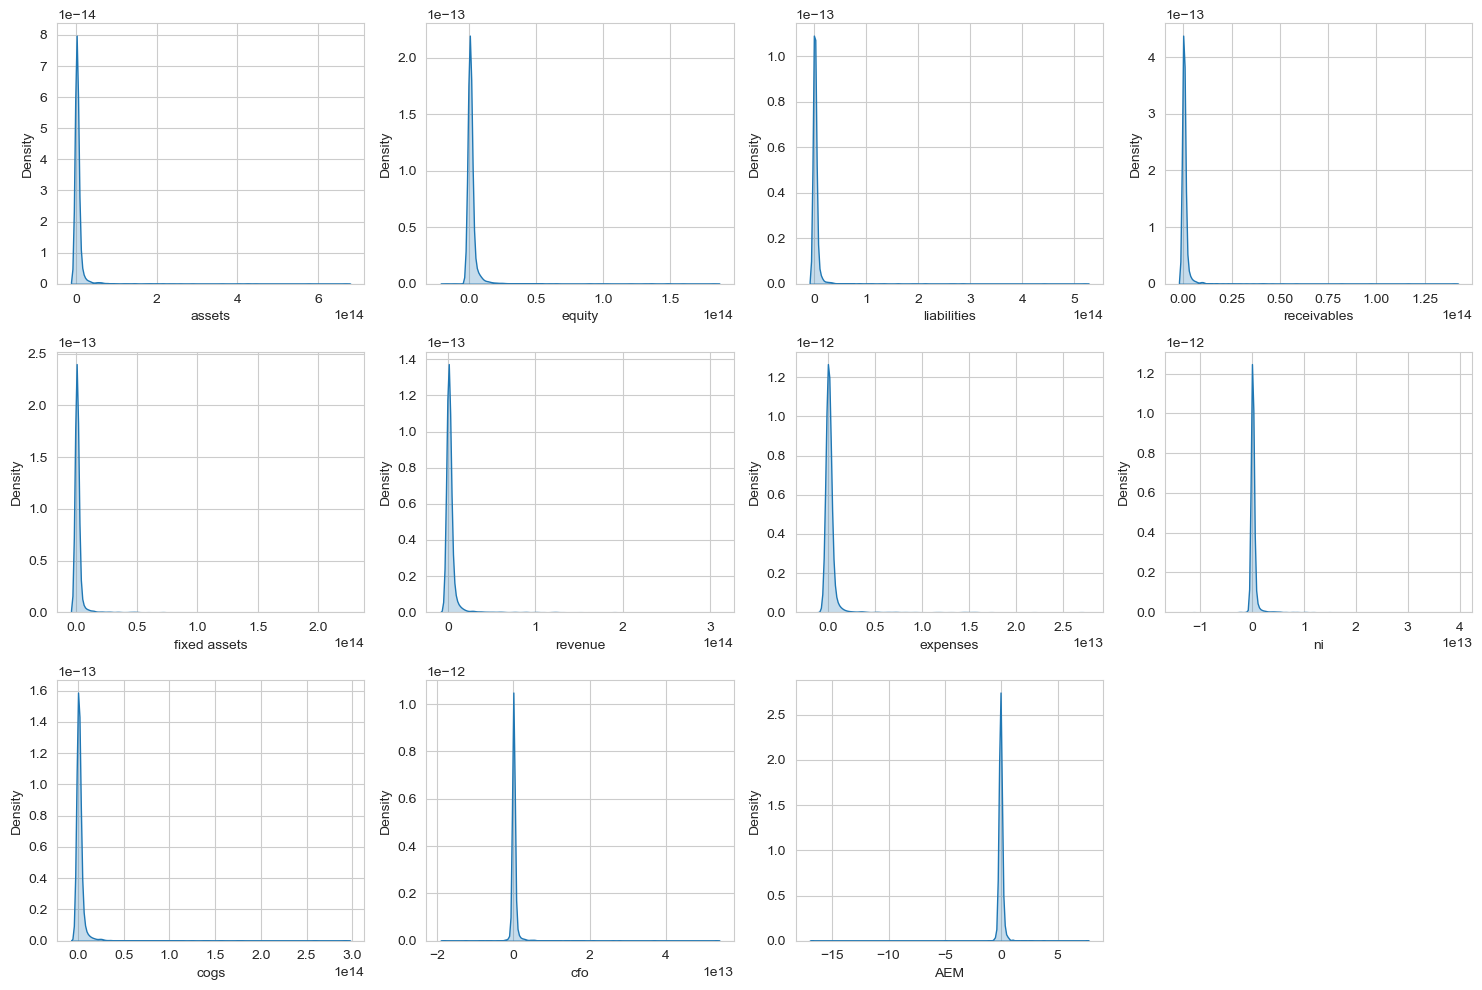

In [20]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 4, i)
    sns.kdeplot(data[column], shade=True)

plt.tight_layout()
plt.show()

BUILDING MACHINE LEARNING MODEL

In [21]:
# Gán nhãn cho AEM
data['AEM_label'] = data['AEM'].apply(lambda x: 1 if x > 0 else 0)

- Nhãn 0: Đại diện cho trường hợp công ty có xu hướng low earnings management (ghi nhận thu nhập thấp hơn thực tế).
- Nhãn 1: Đại diện cho trường hợp công ty có dấu hiệu high earnings management (ghi nhận thu nhập cao hơn thực tế).

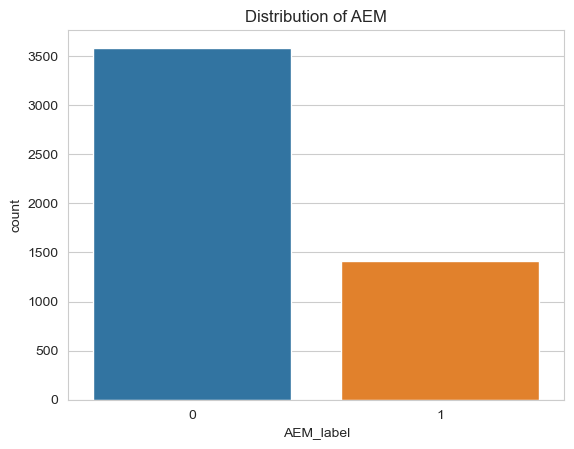

In [22]:
# Check the balance of the target variable
sns.countplot(x=data['AEM_label'])
plt.title('Distribution of AEM')
plt.show()

In [23]:
data['AEM_label'].value_counts()

AEM_label
0    3586
1    1413
Name: count, dtype: int64

In [24]:
# Chuẩn bị dữ liệu
X = data.drop(columns=['AEM', 'AEM_label'])
y = data['AEM_label']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Sử dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [26]:
# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[681  35]
 [ 38 246]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       716
           1       0.88      0.87      0.87       284

    accuracy                           0.93      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.93      0.93      0.93      1000


Accuracy Score: 0.927


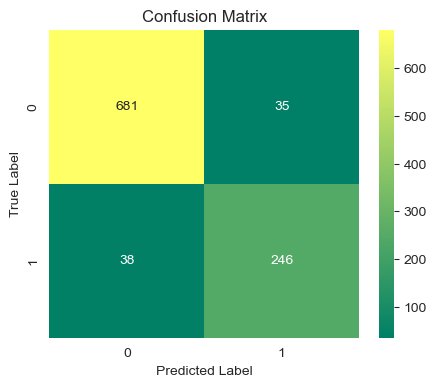

In [27]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="summer", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()